In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import Pool, CatBoostClassifier
from sklearn import metrics
from tqdm import tqdm
from pathlib import Path
import matplotlib.gridspec as gridspec
import matplotlib.colors as plt_colors
import matplotlib as mpl
import copy
import shap
from matplotlib.cm import ScalarMappable

In [2]:
# enable interactivity for shap force plots
shap.initjs()

In [3]:
def load_model(tin):
    ''' load pretrained model from ./data/
    
    params:
    tin: time interval (aka extincion)
         of model to load (string).
         Can assume either 'PTr', 'TrJ',
         or 'KPg'.
         
    returns:
    model: pretrained model of the tin
           extinction
    '''
    model = CatBoostClassifier()
    model.load_model(f"./models/cgb{tin}")
    return model

In [4]:
def load_data(tin):
    ''' load training dataset used for
    the trained model from ./data/
    
    params:
    tin: time interval (aka extincion)
         of model to load (string).
         Can assume either 'PTr', 'TrJ',
         or 'KPg'.
         
    returns:
    data: dataset used to train model of 
          the tin extinction.
    '''
    data = np.load(f'./data/xtrain{tin}.npy', allow_pickle=True)
    return data

In [5]:
def rename_cols(x_train_df):
    ''' reassign dataframe columns their
    correct names (for plotting reasons)
    
    params:
    x_train_df: dataframe of training 
                dataset.
    
    returns:
    x_train_df: same dataframe with up-
                dated column names.
    '''
    x_train_df.rename(columns={0:'Tiering',
                              1:'Motility',
                              2:'Feeding',
                              3:'Protein',
                              4:'Reproduction',
                              5:'Mineralogy',
                              6:'Physiology',
                              7:'Geoplates',
                              8:'Species'}, 
                     inplace=True)
    return x_train_df

In [6]:
def df_preprocessing(x_train):
    ''' prepare dataframe for shap analysis.
        Convert entries to type 'category'.
        Number-codes column names.
    
    params:
    x_train: loaded dataset used for model
             training.
         
    returns:
    x_train_df: same dataset as dataframe with
                adapted formatting.
    '''
    x_train_df = pd.DataFrame(x_train)
    x_train_df = x_train_df.astype('category')
    data_df = rename_cols(x_train_df)
    cleanup_nums = {"Tiering": {"pelagic": 0, "erect": 1, "epifaunal": 2, "semi-infaunal": 3,
                            "shallow infaunal": 4, "deep infaunal": 5},
                "Motility": {"fast, motile": 0, "slow, motile": 1, "facultative, unattached": 2,
                             "facultative, attached": 3, "stationary, unattached": 4,
                             "stationary, attached": 5},
                "Feeding": {"suspension": 0, "surface deposit": 1, "miner": 2, "grazer": 3,
                            "predator": 4, "symbionts": 5},
                "Protein": {'hemerythrin': 0, 'hemocyanin': 1, 'hemoglobin': 2, 'other': 3},
                "Reproduction": {'non-broadcaster': 0, 'intermediate': 1, 'broadcaster': 2},
                "Mineralogy": {'aragonite': 0, 'high Mg calcite': 1, 'low Mg calcite': 2, 'bimineralic': 3,
                               'phosphatic': 4, 'chitin': 5, 'gorgonin': 6, 'silica': 7, 'soft-bodied': 8},
                "Physiology": {'heavy carbonate load': 0, 'moderate carbonate load': 1,
                               'little or no carbonate load': 2}
                   }
    
    for char in cleanup_nums:
            for val in cleanup_nums[char]:
                cleanup_nums[char][val] += 1
        
        # To convert the columns to numbers using replace:
    x_train_df2 = x_train_df.replace(cleanup_nums)
    x_train_df2 = x_train_df2.astype('int')
    x_train_df2["Species"] = np.minimum(10, x_train_df2["Species"].values)
    x_train_df2["Geoplates"] = np.minimum(10, x_train_df2["Geoplates"].values)
    x_train_df2 = x_train_df2.astype('category')
    return x_train_df2

In [7]:
def get_explainer(model, x_train):
    ''' generate tree explainer and calculate
    shap values for the trained model.
    
    params:
    model: loaded, pre-trained, tree-based ML model.
    x_train: dataset used to train this model.
         
    returns:
    explainer: 
    shap_values: Shapley values for quantifying the 
                 importance of each variable/feature
                 to the model prediction
    '''
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_train)
    return explainer, shap_values

In [8]:
# create color vision impairment friendly-colormap
def get_colormap(number_categories):
    ''' create color vision impairment friendly
    categorical colormap. Comes with 14 different
    colors.
    
    params:
    numer_categories: number of different cate-
                      gories needed (max=14).
    
    returns:
    cm: matplotlib colormap element.
    '''
    hex_list = ['#88CCEE', '#882255', '#999933', '#332288', '#DDCC77', '#117733', '#CC6677',
                '#44AA99', '#AA4499', '#DDDDDD', '#C70039', '#000000', '#D55E00', '#0072B2']
    rgb_list = []
    for i in hex_list[:number_categories-1]:
        rgb_list.append(plt_colors.to_rgb(i))
    
    cmap = mpl.colors.ListedColormap(rgb_list)
    cpal = sns.set_palette(sns.color_palette(hex_list))
    return cmap, cpal

In [9]:
def prepare_shap(tin):
    ''' prepare all elements for shap
    plotting.
    
    params:
    tin: time interval (aka extincion)
         of interest (string).
         Can assume either 'PTr', 'TrJ',
         or 'KPg'.
         
    returns:
    shap_values: Matrix of Shapley values.
    x_train_df: dataframe used for model 
                 training.
    curr_max: number of different categories of 
              most diverse feature.
    explainer:
    '''
    model = load_model(tin)
    x_train = load_data(tin)
    x_train_df = df_preprocessing(x_train)
    explainer, shap_values = get_explainer(model, x_train)
    curr_max = 0
    for col in x_train_df:
#         print(x_train_df[col].unique())
#         print(len(x_train_df[col].unique()))
        if np.max(len(x_train_df[col].unique())) > curr_max:
            curr_max = np.max(len(x_train_df[col].unique()))
    return shap_values, x_train_df, curr_max, explainer

In [10]:
def shap_summary_dots(tin):
    ''' plot shap summary as beeswarm plot.
    This is a manual approach to shap.shap_summary
    from the original shap library.
    
    params:
    tin: time interval (aka extincion)
         of interest (string).
         Can assume either 'PTr', 'TrJ',
         or 'KPg'.
    '''
    # prepare dataframes for correct coloring (wide to long df conversion)
    shap_values, x_train_df, max_cats, explainer = prepare_shap(tin)
    x_train_df_long = x_train_df.melt()
    shap_values_long = pd.DataFrame(shap_values).melt()
    x_train_df_long['shap'] = shap_values_long['value']
    cmap, cpal = get_colormap(11)
    
    # get feature importance for ordering
    feature_importance = pd.DataFrame(list(zip(x_train_df.columns, sum(abs(shap_values)))),
                                      columns=['col_name', 'feature_importance_vals'])
    feature_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
    feature_importance

    # do the plotting
    fig = plt.figure(dpi=180)
    fig.set_size_inches(7,3)
    ax = sns.stripplot(y=x_train_df_long['variable'], x=x_train_df_long['shap'], hue=x_train_df_long['value'],
                      order=np.array(feature_importance['col_name']), size=2, jitter=0.25,
                      palette=cpal)
    
    # remove frame and add some lines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_ticks_position('none') 
    plt.xlabel('SHAP value')
    plt.ylabel(tin, fontweight='bold')
    
    plt.axvline(x=0, color='k', linestyle='-', linewidth=0.5)
#     print(x_train_df_long['value'])
#     norm = plt.Normalize(x_train_df_long['value'].min(), x_train_df_long['value'].max())
    norm = plt.Normalize(1, 10)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    ax.get_legend().remove()
    cb = ax.figure.colorbar(sm)
    cb.outline.set_visible(False)
    cb.set_ticks([])
    
    #legend
    cb.ax.get_yaxis().set_ticks([])
    for j in range(0, max_cats):
        py = 0.91 * j + 1.2
        if j < 9:
            cb.ax.text(13, py, j + 1)
        else:
            cb.ax.text(13, py, f"{j + 1}+")
    cb.ax.get_yaxis().labelpad = 15
    cb.ax.set_ylabel('category (cf. Table 1)', rotation=90, labelpad=25)
    
    # finally show the plot
    fig.tight_layout()
    fig.savefig(f"./images/shap_summary_plot_{tin}")
    plt.show()

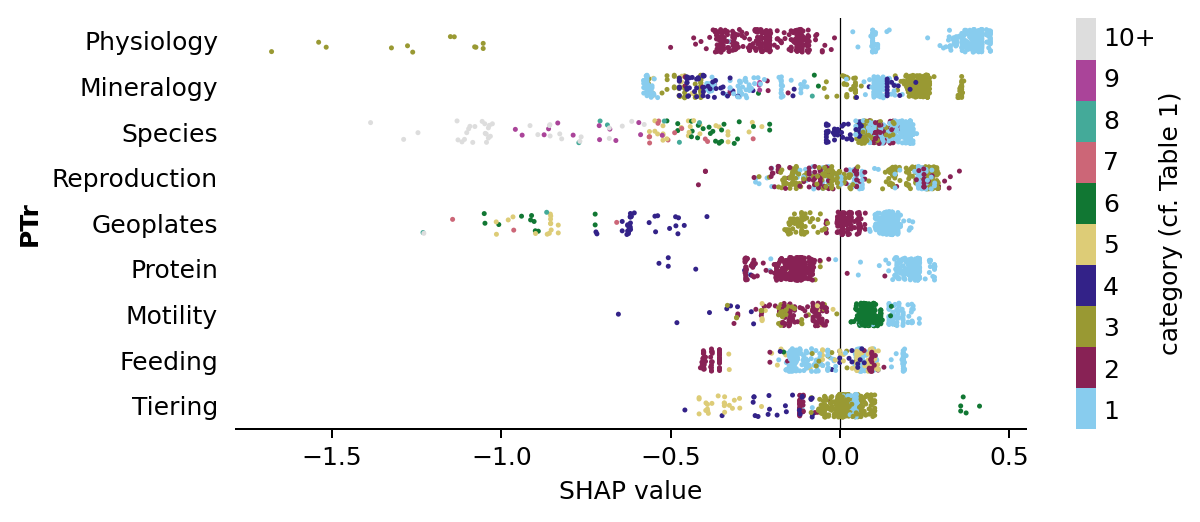

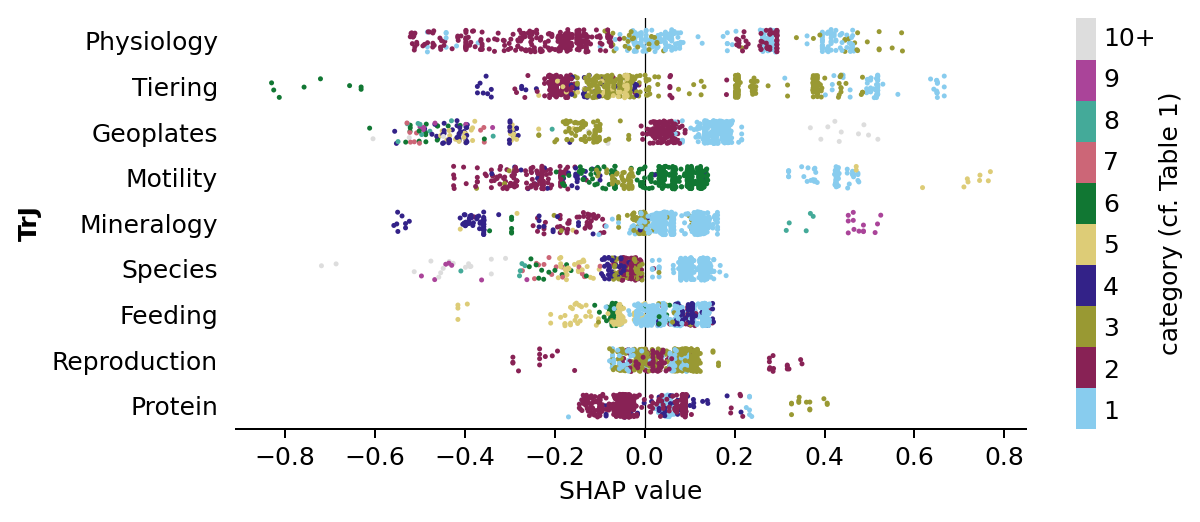

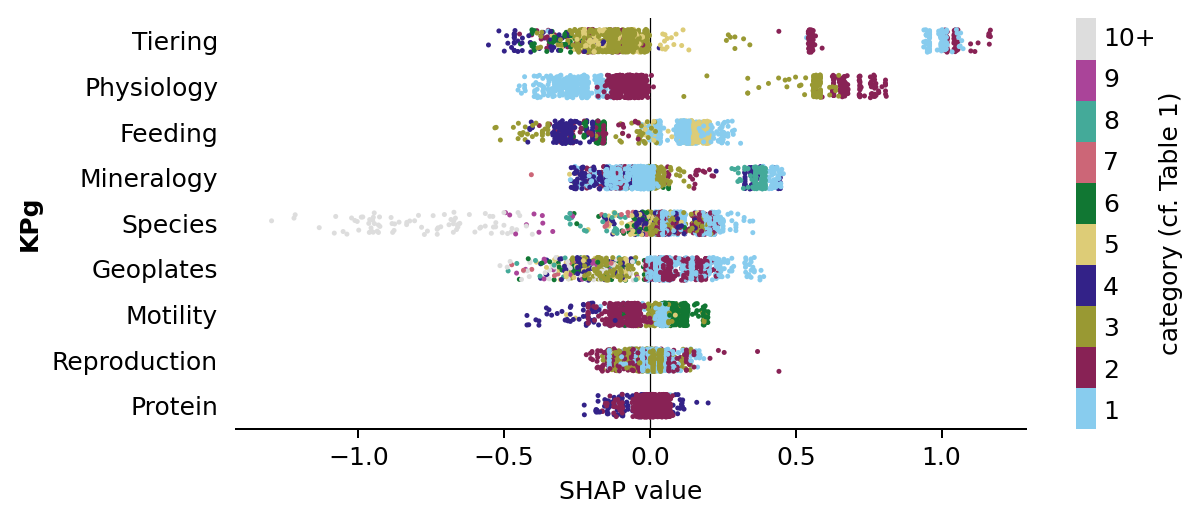

In [11]:
shap_summary_dots('PTr')
shap_summary_dots('TrJ')
shap_summary_dots('KPg')

In [12]:
def determine_sample_ind(tin, fg_traits):
    ''' find index of sample to plot
    in shap foce plot absed on ecological 
    traits.
    
    params:
    tin:
    fg: array of traits of funcitonal group
    
    returns:
    ms_ind: index of metaspecies with
            specified ecological traits.
    '''
    data = load_data(tin)
#     ms_list = pd.read_csv('./data/metaspecies/metaspecies_geo_sp.csv').to_numpy()
#     fg_traits = ms_list[fg-1]
    data_df = pd.DataFrame(data[:, :])
    rename_cols(data_df)
    print(fg_traits)

    ms = data_df.loc[(data_df['Tiering'] == fg_traits[0])
                     & (data_df['Motility'] == fg_traits[1]) 
                     & (data_df['Feeding'] == fg_traits[2])
                     & (data_df['Protein'] == fg_traits[3])
                     & (data_df['Reproduction'] == fg_traits[4])
                     & (data_df['Mineralogy'] == fg_traits[5]) 
                     & (data_df['Physiology'] == fg_traits[6]) 
                     & (data_df['Geoplates'] == fg_traits[7])
                     & (data_df['Species'] == fg_traits[8])]
    ms_ind = ms.index
    print(ms_ind)
    return ms_ind[0]

In [13]:
def make_force_plot(tin, s_ind):
    ''' make force plots for specific samples.
    
    params:
    tin: time interval (aka extincion)
         of interest (string).
         Can assume either 'PTr', 'TrJ',
         or 'KPg'.
    s_ind: index of sample to plot in dataset.
    '''
    shap_values, x_train_df, curr_max, explainer = prepare_shap(tin)
    x_train_cat = load_data(tin)
    x_train_df_cat = pd.DataFrame(x_train_cat)
    x_train_df_cat = x_train_df_cat.astype('category')
    x_train_df_cat = rename_cols(x_train_df_cat)
    display(shap.force_plot(explainer.expected_value,
                            shap_values[s_ind, :],
                            x_train_df_cat.iloc[s_ind,:],
                            link='logit',
                            out_names="Extinction Probability",
                            plot_cmap=["#75485e", "#51a3a3"],
                            show=False))

In [17]:
# make force plots for the same metaspecies throughout the three extinction intervals.
# please provide traits of the functional group you wish to plot here:
# in this order:
# tiering - motility - feeding - protein - reproduction - mineralogy - physiology - geoplates - species
fg_traits = ['epifaunal', 'stationary, attached', 'suspension', 'hemerythrin', 'broadcaster',
             'low Mg calcite', 'heavy carbonate load', 2, 2]

ms_ind = determine_sample_ind('PTr', fg_traits)
make_force_plot('PTr', ms_ind)

ms_ind = determine_sample_ind('TrJ', fg_traits)
make_force_plot('TrJ', ms_ind)

ms_ind = determine_sample_ind('KPg', fg_traits)
make_force_plot('KPg', ms_ind)

['epifaunal', 'stationary, attached', 'suspension', 'hemerythrin', 'broadcaster', 'low Mg calcite', 'heavy carbonate load', 2, 2]
Int64Index([105, 111, 121, 128, 131, 176, 190, 200, 208, 214, 230, 247, 269,
            315],
           dtype='int64')


['epifaunal', 'stationary, attached', 'suspension', 'hemerythrin', 'broadcaster', 'low Mg calcite', 'heavy carbonate load', 2, 2]
Int64Index([39, 48, 54, 59, 71, 86, 92, 95, 107], dtype='int64')


['epifaunal', 'stationary, attached', 'suspension', 'hemerythrin', 'broadcaster', 'low Mg calcite', 'heavy carbonate load', 2, 2]
Int64Index([126, 127, 143, 145, 146], dtype='int64')
